In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

In [2]:
with open('hpath.pkl', 'rb') as f:
    hpath_x, hpath_y = np.load(f, allow_pickle = True)
hpath = np.array([np.array([hpath_x[i], hpath_y[i]]) for i in range(len(hpath_x))])

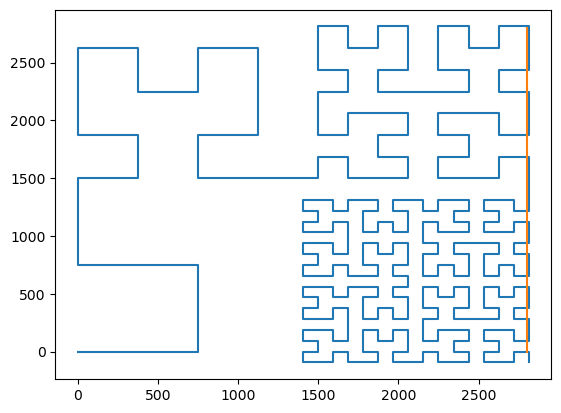

In [3]:
plt.plot(hpath[:, 0], hpath[:, 1])
test = 2800
plt.plot([test, test],[0, test])
plt.show()

In [4]:
print(hpath[-1])
print(hpath[-1] - hpath[-2])

[2812.5   -93.75]
[  0.   -93.75]


In [5]:
def sample_hpath_even(path, mindist):
    newpath_x = np.array([0])
    newpath_y = np.array([0])

    for i in range(path.shape[0] - 1):
        dist = path[i+1]-path[i]
        if np.linalg.norm(dist) > mindist:
            npoints = int(max(round(abs(dist[0]/mindist)), round(abs(dist[1]/mindist))))
            xs, ys = [], []
            # exploits fact that it only makes 90deg turns
            if(abs(dist[0]) > 0):
                xs = np.linspace(path[i, 0], path[i+1, 0], npoints)
                ys = np.array([path[i, 1] for _ in range(npoints)])
            else:
                xs = np.array([path[i, 0] for _ in range(npoints)])
                ys = np.linspace(path[i, 1], path[i+1, 1], npoints)
    
            newpath_x = np.concatenate((newpath_x, xs, [path[i+1, 0]]))
            newpath_y = np.concatenate((newpath_y, ys, [path[i+1, 1]]))

    return np.vstack((np.array(newpath_x), np.array(newpath_y))).T * 3000/path[-1, 0]  #normalizes to width 3000
sampled_hpath = sample_hpath_even(hpath, 1.25) 

In [6]:
print(sampled_hpath[-1])
print(sampled_hpath.shape)

[3000. -100.]
(36265, 2)


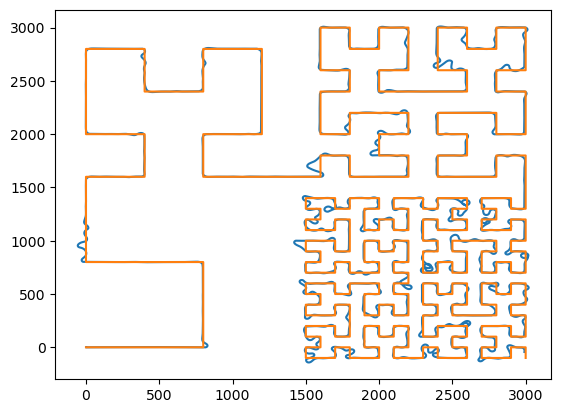

In [7]:
#loads flighpath and trims landing pattern
def load_flightlog(path):
    df = pd.read_csv(path)
    path = np.transpose(np.stack((df["y"], df["x"])))
    endpoint = np.array([3000,   -93.75])
    last_idx = 0
    while not np.linalg.norm(path[last_idx, :]-endpoint)<50:
        last_idx+=1
    #print(last_idx)
    #print(path.shape)
    path = np.array([path[i] for i in range(last_idx)])
    return path
test_log = load_flightlog("rcac_autopilot/fuzzed/fzl0_vehicle_local_position_0.csv")
plt.plot(test_log[:, 0], test_log[:,1])
plt.plot(sampled_hpath[:,0],sampled_hpath[:, 1])
plt.show()

In [8]:
def log2path(sim_type, autopilot_type, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = autopilot_type+"_autopilot/vanilla/vl" if sim_type == "vanilla" else autopilot_type+"_autopilot/fuzzed/fzl"
    fname = prefix + str(index) + "_vehicle_local_position_0.csv"
    return load_flightlog(fname)


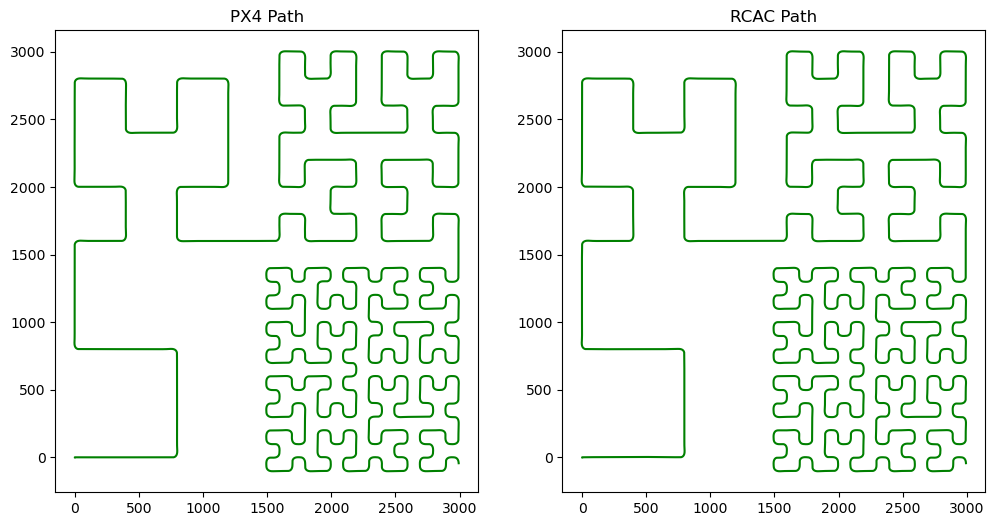

In [42]:
px4_v_ex = log2path("vanilla", "standard", 0)
px4_f_ex = log2path("fuzzed", "standard", 0)
rcac_v_ex = log2path("vanilla", "rcac", 0)
rcac_f_ex = log2path("fuzzed", "rcac", 0)
#fig, axarr = plt.subplots(2,2)
fig = plt.figure(figsize=(12,6))
ax00 = fig.add_subplot(121)
ax00.plot(px4_v_ex[:,0], px4_v_ex[:, 1], 'g')
ax00.set_title("PX4 Path")
ax11 = fig.add_subplot(122)
ax11.plot(rcac_v_ex[:,0], rcac_v_ex[:, 1], 'g')
ax11.set_title("RCAC Path")
plt.show()


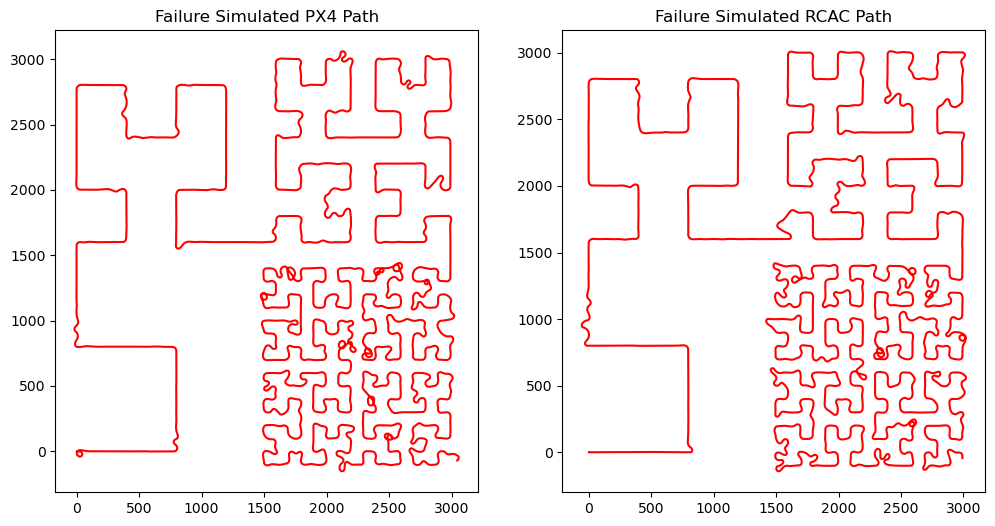

In [41]:
fig = plt.figure(figsize=(12,6))

ax01 = fig.add_subplot(121)
ax01.plot(px4_f_ex[:,0], px4_f_ex[:, 1], 'r')
ax01.set_title("Failure Simulated PX4 Path")
ax10 = fig.add_subplot(122)
ax10.plot(rcac_f_ex[:,0], rcac_f_ex[:, 1], 'r')
ax10.set_title("Failure Simulated RCAC Path")
plt.show()

In [11]:
num_trials = 5
vanilla_px4_dists = []
for i in range(num_trials):
    trial = log2path("vanilla", "standard", i)
    dist, _ = fastdtw(trial, sampled_hpath)
    vanilla_px4_dists.append(dist)

num_trials = 8
fuzzed_px4_dists = []
for i in range(num_trials):
    trial = log2path("fuzzed", "standard", i)
    dist, _ = fastdtw(trial, sampled_hpath)
    fuzzed_px4_dists.append(dist)
    

num_trials = 5
vanilla_rcac_dists = []
for i in range(num_trials):
    trial = log2path("vanilla", "rcac", i)
    dist, _ = fastdtw(trial, sampled_hpath)
    vanilla_rcac_dists.append(dist)
    

num_trials = 12
fuzzed_rcac_dists = []
for i in range(num_trials):
    trial = log2path("fuzzed", "rcac", i)
    dist, _ = fastdtw(trial, sampled_hpath)
    fuzzed_rcac_dists.append(dist)

[(213265.87379291694, 1591.89325171546, 0.7464359971915632), (354075.10578792053, 23765.871713070046, 6.712099022094208), (208994.0412404098, 343.0305701092469, 0.1641341389799015), (372809.7412926124, 26602.193805774972, 7.135595146612689)]


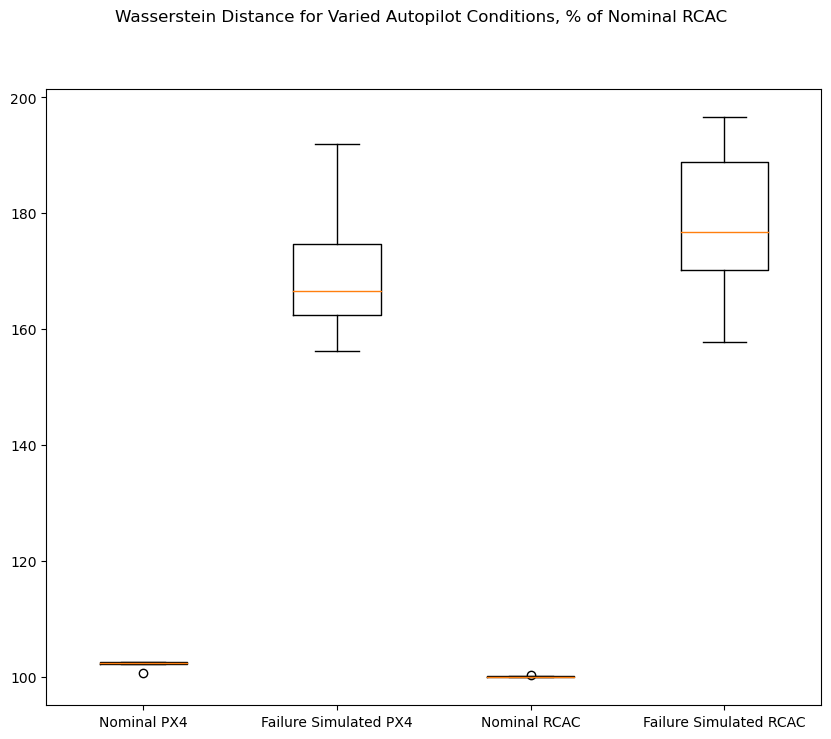

In [40]:
data = (vanilla_px4_dists, fuzzed_px4_dists, vanilla_rcac_dists, fuzzed_rcac_dists)
np.savetxt("distances.csv", np.hstack(data), delimiter=',')
#print(data)
from  statistics import mean, stdev
print([(mean(d), stdev(d), 100*stdev(d)/mean(d)) for d in data])
labels = ["Nominal PX4","Failure Simulated PX4", "Nominal RCAC", "Failure Simulated RCAC"]
fig = plt.figure(figsize = (10,8))
bplot = plt.boxplot(list((np.array(d)*100.0*(1/mean(vanilla_rcac_dists)) for d in data)), vert = True, labels = labels)#, patch_artist = True)
fig.suptitle("Wasserstein Distance for Varied Autopilot Conditions, % of Nominal RCAC")
plt.show()